# Using the LASSO for inference and prediction

* Stepwise linear regression is time consuming - the p-values are unstable and are path-dependent
* Would be nice to have the optimal subset of variables selected in an unbiased way
* Use LASSO/Ridge/ElasticNet for wide data
* Can use LASSO for unbiased feature selection
* LASSO uses regularization which penalizes high coefficients
* Lambda parameter analogy to garden hose - most important features start to trickle through as you open the valve

In [1]:
# Package "glmnet" contains the LASSO function
# install.packages( 'glmnet' )
library( glmnet )

# Package "mice" is for imputation of missing data
#install.packages( 'mice' )
library( mice )

# Metapackage "tidyverse" imports libraries 
# for data manipulation (dplyr) and plotting (ggplot2)
library( tidyverse )

# Package "readxl" has the read_excel() function
library( readxl )

# Package "skimr" has excellent descriptive statistics
# function skim_to_wide()
library( skimr )

# Package "GGally" has ggplot2-style scatterplot matrices
library( GGally )

# Package "ggfortify" has ggplot2-style regression diagnostic plots
#install.packages( 'ggfortify' )
library( ggfortify )

# Package tictoc has functions to time function calls
library( tictoc )

# Package "glmnetUtils" allows the use of R formulas for
# specifying glmnet models (as opposed to converting to matrices)
#library(devtools)
#install_github("hong-revo/glmnetUtils")
library(glmnetUtils)

# Package "broom" for tidy() function for pulling
# regression coefficients from glmnet models
library( broom )

# Package "rsample" for train/test split utilities
library( rsample )

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18

Loading required package: lattice

Attaching package: ‘mice’

The following objects are masked from ‘package:base’:

    cbind, rbind

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::complete()   masks mice::complete()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::w

# Load data

* NYtowns dataset - marketing data
* [Product] Penetration is target variable
* Many other variables, mostly demographic data

In [2]:
data <- read_excel( 'NYTowns.xlsx' )

In [3]:
data %>% dim 

[1] 1006  248

In [4]:
data <- data %>% 
    #select( -starts_with( 'Anc') ) %>%
    select( -c( 'GEO_ID', "GEO_NAME", "NAME") )

# Exploratory: univariate

* Distribution of Penetration is right skew and non-negative; not a count, but more like a rate

In [5]:
# A Jupyter Notebook-specific directive
# sets the maximum number of rows to something above what is needed
# to show everything
options( repr.matrix.max.rows=300 )

In [6]:
skim_to_wide( data ) %>% select( -type, -n )

variable,missing,complete,mean,sd,p0,p25,p50,p75,p100,hist
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AncArab,0,1006,0.28,0.43,0,0,0.2,0.4,5.8,▇▁▁▁▁▁▁▁
AncCzech,0,1006,0.49,0.5,0,0.1,0.4,0.7,4.2,▇▃▁▁▁▁▁▁
AncDanish,0,1006,0.37,0.61,0,0.1,0.2,0.5,9.4,▇▁▁▁▁▁▁▁
AncDutch,0,1006,4.16,2.87,0,2.3,3.7,5.2,33.6,▇▅▁▁▁▁▁▁
AncEnglish,0,1006,14.37,5.39,0,10.6,14.5,18.1,29.1,▁▂▅▇▇▆▂▁
AncFrCanad,0,1006,2.07,2.35,0,0.8,1.4,2.4,21.1,▇▂▁▁▁▁▁▁
AncFrench,0,1006,6.58,6.47,0,3,4.4,7.7,54.2,▇▂▁▁▁▁▁▁
AncGerman,0,1006,19.89,8.34,0,14.8,19.4,24.1,54.1,▁▃▇▆▂▁▁▁
AncGreek,0,1006,0.34,0.49,0,0,0.2,0.5,8.4,▇▁▁▁▁▁▁▁


# Optional: impute missing data

In [7]:
data %>% is.na %>% sum 

[1] 190

In [8]:
tic()
imputation_model <- mice( data, method='cart', m=1, maxit=1 )
toc()


 iter imp variable
  1   1  GPGuardP  BornEurope  BornAsia  BornAfrica  BornOceania  BornLatAmer  BornNorAmer  IncAvgSupSec  IncAvgPubAss  FSChilPP  PovFamWBaby  PovFamNoHusband  PovFamChildNoHusband  MarFemaleWidows  RentDivIncLT15  RentDivIncLT20  RentDivIncLT25  RentDivIncLT30  RentDivIncLT35


Warning message:
“Number of logged events: 23”

27.761 sec elapsed


In [9]:
#glimpse( imputation_model )

In [10]:
imputed_data <- mice::complete( imputation_model )

In [11]:
imputed_data %>% is.na %>% sum

[1] 0

# To evaluate predictions, split into train and test set

In [12]:
set.seed( 42 )
data_splitter <- initial_split( imputed_data, prop=0.8 )
train_data <- training( data_splitter )
test_data <- testing( data_splitter )

# Perform LASSO

* Plain vanilla model (gaussian family w/identity link function)
    * Baseline: fitting linear model to poisson-style data
* Vary lambda regularization parameter, observe coefficient paths as lambda varies
    * By default, it will generate 100 different models with 100 different lambdas
    * A reasonable range of lambda vales are selected for you by default, also you can specify your own (or a range of lambdas)
* LASSO corresponds with glmnet with argument $\alpha=1$ which is default
* glmnet standardized variables by default, so regression coefficients $\beta_i$ is interpretable as relative importances
* Use ```dfmax``` argument to limit number of variables included in the model 

In [13]:
glmnet_lm_result <- glmnet( Penetration ~ ., data=train_data )

In [14]:
print( glmnet_lm_result )

Call:
glmnet.formula(formula = Penetration ~ ., data = train_data)

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Alpha: 1
    Lambda summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000470 0.004705 0.047063 0.529144 0.470507 4.701200 



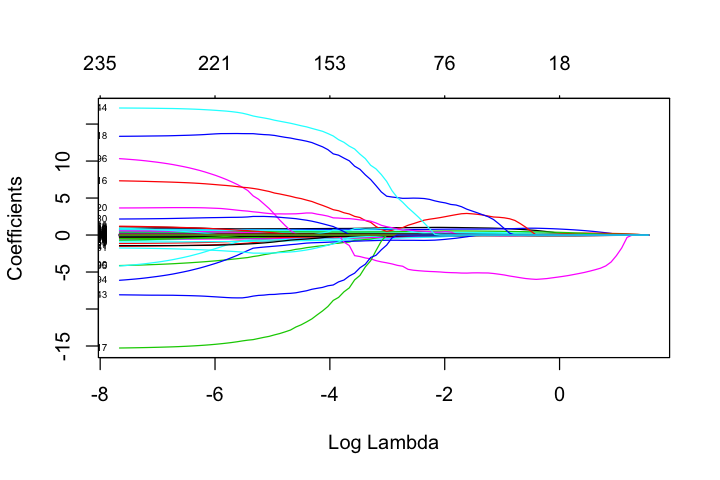

In [15]:
options(repr.plot.width=6, repr.plot.height=4)
plot( glmnet_lm_result, xvar='lambda', label=TRUE )
# can also use ggfortify version, which doesn't work very well with many variables
#options(repr.plot.width=30, repr.plot.height=30 )
#autoplot( glmnet_lm_result, label=FALSE )
#plot_glmnet( glmnet_lm_result, xvar='lambda', label=TRUE )

## How many times does a given variable appear in a model?

In [16]:
glmnet_lm_result %>%                 # Take the glmnet result object
    coef %>%                         # get all the coefficients for all 100 models (lambdas)
    t %>%                            # transpose so the variables are in the columns
    as.matrix %>% as.data.frame %>%  # convert to something the tidyverse can manipulate
    map_int( ~ sum( . != 0 ) ) %>%   # For each column, return a count
    sort( decreasing = TRUE ) %>%    # sort from highest to lowest
    head( 40 )  %>%                  # show the top 20 used variables
    print

       (Intercept)   HouseMultiFamily         AncItalian         ValueLT50K 
               100                 98                 97                 95 
       BadPlumbing         NoCashRent       LessEq2Rooms           EduHSDip 
                94                 94                 92                 91 
    JobAgriculture MarFemaleDivorcees      WorkClassSelf       BuiltAfter90 
                89                 88                 87                 86 
          AncSwiss      CommuteAtHome           PopRural       JobConstruct 
                85                 82                 82                 81 
      BuiltAfter70            SchNurs     JobOfficeSales        EduColNoDeg 
                80                 79                 79                 78 
        BadKitchen CommuteAvgTravTime     CostDivIncLT15           VehicGT1 
                78                 78                 78                 78 
   IndConstruction          Resid5Yrs           IndAgric      PovIndSeniors 

# Which lambda gives the best model? 

* BEST lambda is given by “lambda.min”: the λ at which the minimal MSE is achieved
* Use ```cv.glmnet()``` - Perform CROSS-VALIDATION LASSO
* Again, plain vanilla model (gaussian family w/identity link function)
* 10-fold cross validation to find optimal lambda parameter

In [17]:
tic()
glmnet_cv_result <- cv.glmnet( Penetration ~ ., data=train_data )
toc()

1.736 sec elapsed


In [18]:
print( glmnet_cv_result )

Call:
cv.glmnet.formula(formula = Penetration ~ ., data = train_data)

Model fitting options:
    Sparse model matrix: FALSE
    Use model.frame: FALSE
    Number of crossvalidation folds: 10
    Alpha: 1
    Deviance-minimizing lambda: 0.2182104  (+1 SE): 0.6071833


In [19]:
glmnet_cv_result$lambda.min

[1] 0.2182104

In [20]:
options(repr.plot.width=6, repr.plot.height=5)

In [21]:
log( glmnet_cv_result$lambda.min )

[1] -1.522296

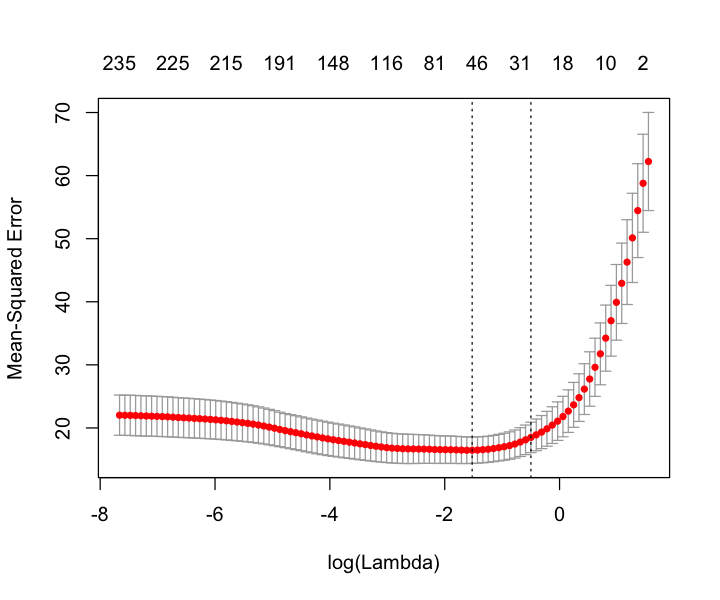

In [22]:
plot( glmnet_cv_result )

## Given the best lambda, what are the regression coefficients?

* Remember, glmnet regression coefficients are standardized
    * Betas aren't in original units
    * Betas double as feature importances
    * To keep original units, use argument standardize=False in glmnet function call

In [23]:
lm_coefs <- glmnet_cv_result %>% 
    coef( s = "lambda.min" ) %>%    # Get the betas from the best model
    tidy %>%                        # Put betas into a data.frame
    select( -column ) %>%           # prune unimportant column named "column"
    arrange( desc( abs( value ) ) ) # Sort by absolute value

Warning message:
“'tidy.dgCMatrix' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.dgTMatrix' is deprecated.
See help("Deprecated")”

In [24]:
head( lm_coefs, 30 )

row,value
<chr>,<dbl>
(Intercept),-18.37737222
MarFemaleDivorcees,-5.11554208
CostDivIncLT25,3.24460585
CostDivIncLT15,2.86530431
AncSwiss,0.98236846
BadPlumbing,0.80539507
LessEq2Rooms,0.54193077
BadKitchen,0.32900049
JobAgriculture,0.32006860


# Use best lambda for prediction

* For functions like ```predict()```, arg ```s``` is where you input lambda

In [25]:
dim( train_data )

[1] 805 245

In [26]:
lm_ypred <- predict( 
    glmnet_cv_result, test_data, s="lambda.min" ) %>%
    as.numeric # convert predictions to R vector from R matrix

In [27]:
length(lm_ypred)

[1] 201

In [28]:
all_pred_results <- tibble( y=test_data$Penetration, glmnet_linear=lm_ypred )

## Model achieves training R-squared of 0.72

In [29]:
summary( lm( glmnet_linear ~ y, all_pred_results) )


Call:
lm(formula = glmnet_linear ~ y, data = all_pred_results)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.4435  -2.0476  -0.1604   1.7866  17.6349 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.41597    0.39526   6.112 5.09e-09 ***
y            0.76420    0.03323  23.000  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.717 on 199 degrees of freedom
Multiple R-squared:  0.7266,	Adjusted R-squared:  0.7253 
F-statistic:   529 on 1 and 199 DF,  p-value: < 2.2e-16


## Make plot of predicted vs actual

* Note negative predictions!!!

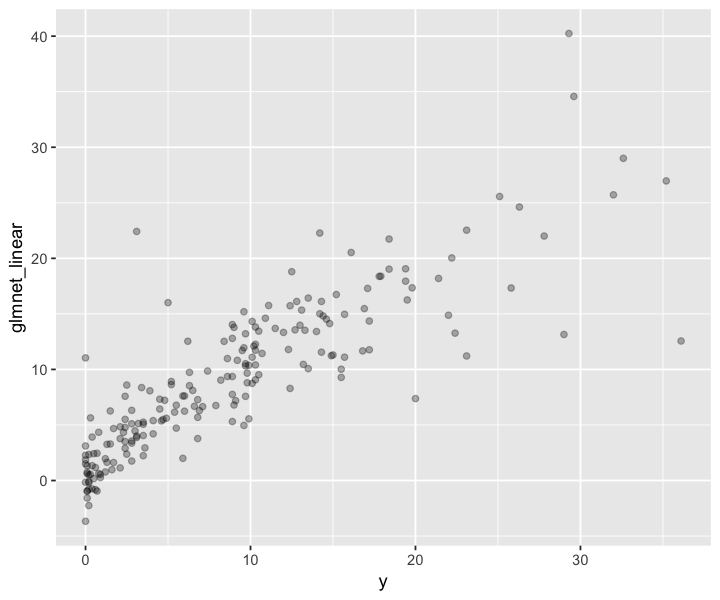

In [30]:
ggplot( all_pred_results, aes( y, glmnet_linear ) ) + 
    geom_point( alpha=0.3 )

## Make log-log plot of predicted vs actual

* ggplot throws warning messages because it can't handle log transformations of negative predictions - it drops them from the figure.

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 12 rows containing missing values (geom_point).”

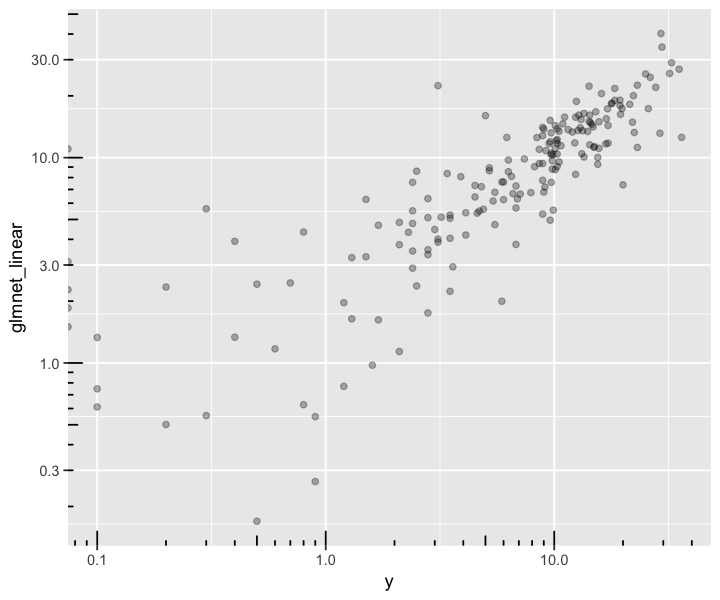

In [31]:
ggplot( all_pred_results, aes( y, glmnet_linear ) ) + 
    geom_point( alpha=0.3 ) + 
    scale_x_continuous(trans = 'log10') + 
    scale_y_continuous(trans = 'log10') +
    annotation_logticks()

# Slightly better: Generalized Linear model

* Model the outcome variable ```Penetration``` as having a poisson distribution
* Use cross validation to find optimal lambda, then make predictions with that lambda.
* [GLM offsets](https://statisticaloddsandends.wordpress.com/2019/01/09/a-deep-dive-into-glmnet-offset/) - advanced topic not covered here

In [32]:
tic()
glmnet_cv_result2 <- cv.glmnet( Penetration ~ ., data=train_data, family='poisson' )
toc()

12.1 sec elapsed


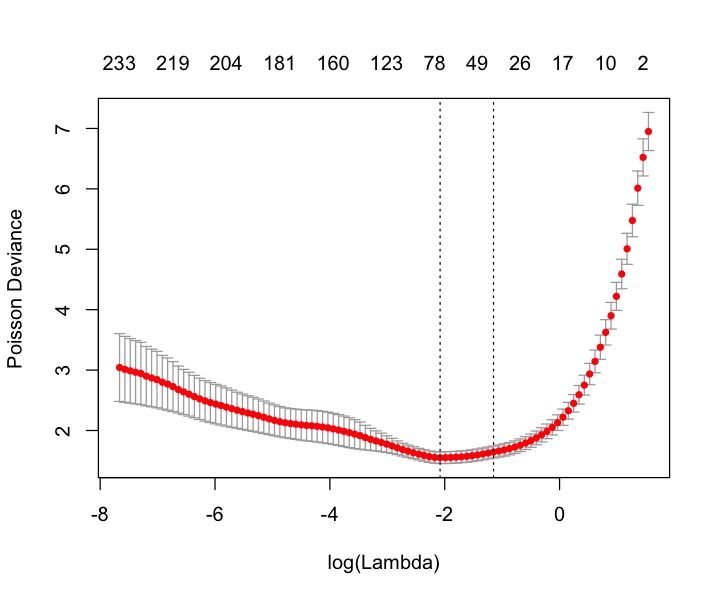

In [33]:
plot( glmnet_cv_result2 )

In [34]:
lm2_ypred <- predict( 
    glmnet_cv_result2, test_data, s="lambda.min", type = "response" ) %>%
    as.numeric # convert to R vector from R matrix

In [35]:
length( lm2_ypred )

[1] 201

In [36]:
all_pred_results <- all_pred_results %>%
    mutate( glmnet_poisson = lm2_ypred )

## Poisson-style glmnet model R-squared is comparable to linear-style glmnet model

In [37]:
summary( lm( glmnet_poisson ~ y, all_pred_results) )


Call:
lm(formula = glmnet_poisson ~ y, data = all_pred_results)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.227  -1.217  -0.325   1.229  32.886 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.63093    0.45776   3.563 0.000459 ***
y            0.86952    0.03848  22.596  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.305 on 199 degrees of freedom
Multiple R-squared:  0.7196,	Adjusted R-squared:  0.7182 
F-statistic: 510.6 on 1 and 199 DF,  p-value: < 2.2e-16


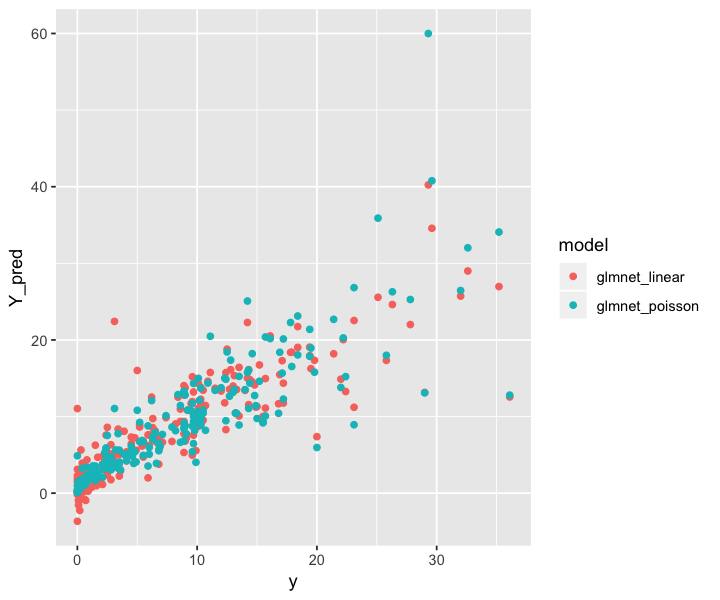

In [38]:
all_pred_results %>% 
    gather( key='model', value='Y_pred', -y ) %>%
    ggplot( aes( y, Y_pred, color=model) ) + geom_point()

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 12 rows containing missing values (geom_point).”

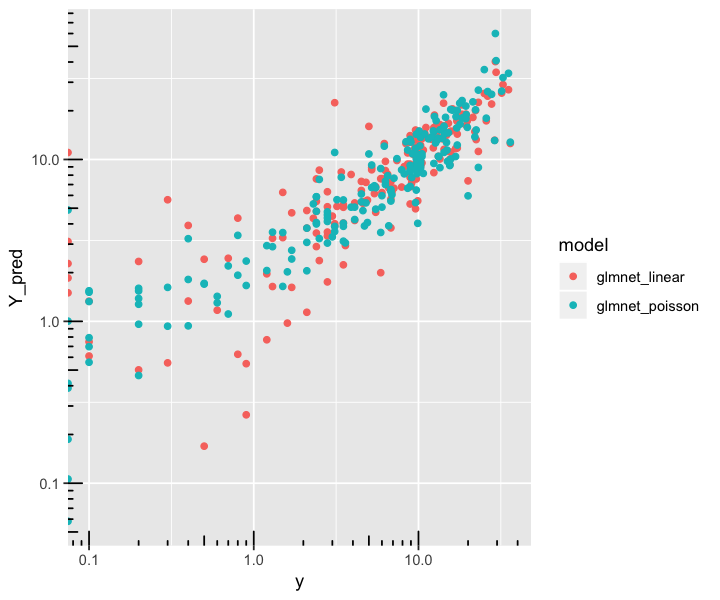

In [39]:
all_pred_results %>% 
    gather( key='model', value='Y_pred', -y ) %>%
    ggplot( aes( y, Y_pred, color=model) ) + geom_point() +
    scale_x_continuous(trans = 'log10') + 
    scale_y_continuous(trans = 'log10') +
    annotation_logticks()

# Use glmnet coefs for variable selection

In [40]:
# remove row marked '(Intercept)'
interesting_linear_vars <- c( setdiff( lm_coefs[1:15,'row'],  '(Intercept)'), 'Penetration' )

In [41]:
interesting_linear_vars

[1] "MarFemaleDivorcees" "CostDivIncLT25"     "CostDivIncLT15"    
 [4] "AncSwiss"           "BadPlumbing"        "LessEq2Rooms"      
 [7] "BadKitchen"         "JobAgriculture"     "WorkClassSelf"     
[10] "IncRatioM2F"        "VehicGT1"           "SchNurs"           
[13] "EduHSDip"           "EduColNoDeg"        "Penetration"

In [42]:
train_data_subset <- train_data %>% select( interesting_linear_vars )

## Exploratory: Univariate and Bivariate dists

In [43]:
skim_to_wide( train_data_subset )  %>% select( -type, -n )

variable,missing,complete,mean,sd,p0,p25,p50,p75,p100,hist
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AncSwiss,0,805,0.42,0.62,0,0.1,0.2,0.5,5.7,▇▁▁▁▁▁▁▁
BadKitchen,0,805,0.68,1.3,0,0.1,0.4,0.9,24.9,▇▁▁▁▁▁▁▁
BadPlumbing,0,805,0.74,1.33,0,0.2,0.4,0.9,24.4,▇▁▁▁▁▁▁▁
CostDivIncLT15,0,805,0.37,0.075,0.19,0.33,0.37,0.42,0.73,▁▅▇▆▂▁▁▁
CostDivIncLT25,0,805,0.7,0.063,0.47,0.66,0.7,0.74,0.91,▁▁▂▇▇▃▁▁
EduColNoDeg,0,805,17.24,2.92,5.2,15.6,17.4,19.2,25.6,▁▁▁▃▇▇▂▁
EduHSDip,0,805,36.23,7.89,6,31.4,37.2,41.5,59.4,▁▁▂▅▇▇▂▁
IncRatioM2F,0,805,1.39,0.18,0.5,1.28,1.38,1.5,2.35,▁▁▂▇▅▁▁▁
JobAgriculture,0,805,1.54,1.66,0,0.3,1.1,2.2,12.5,▇▃▁▁▁▁▁▁


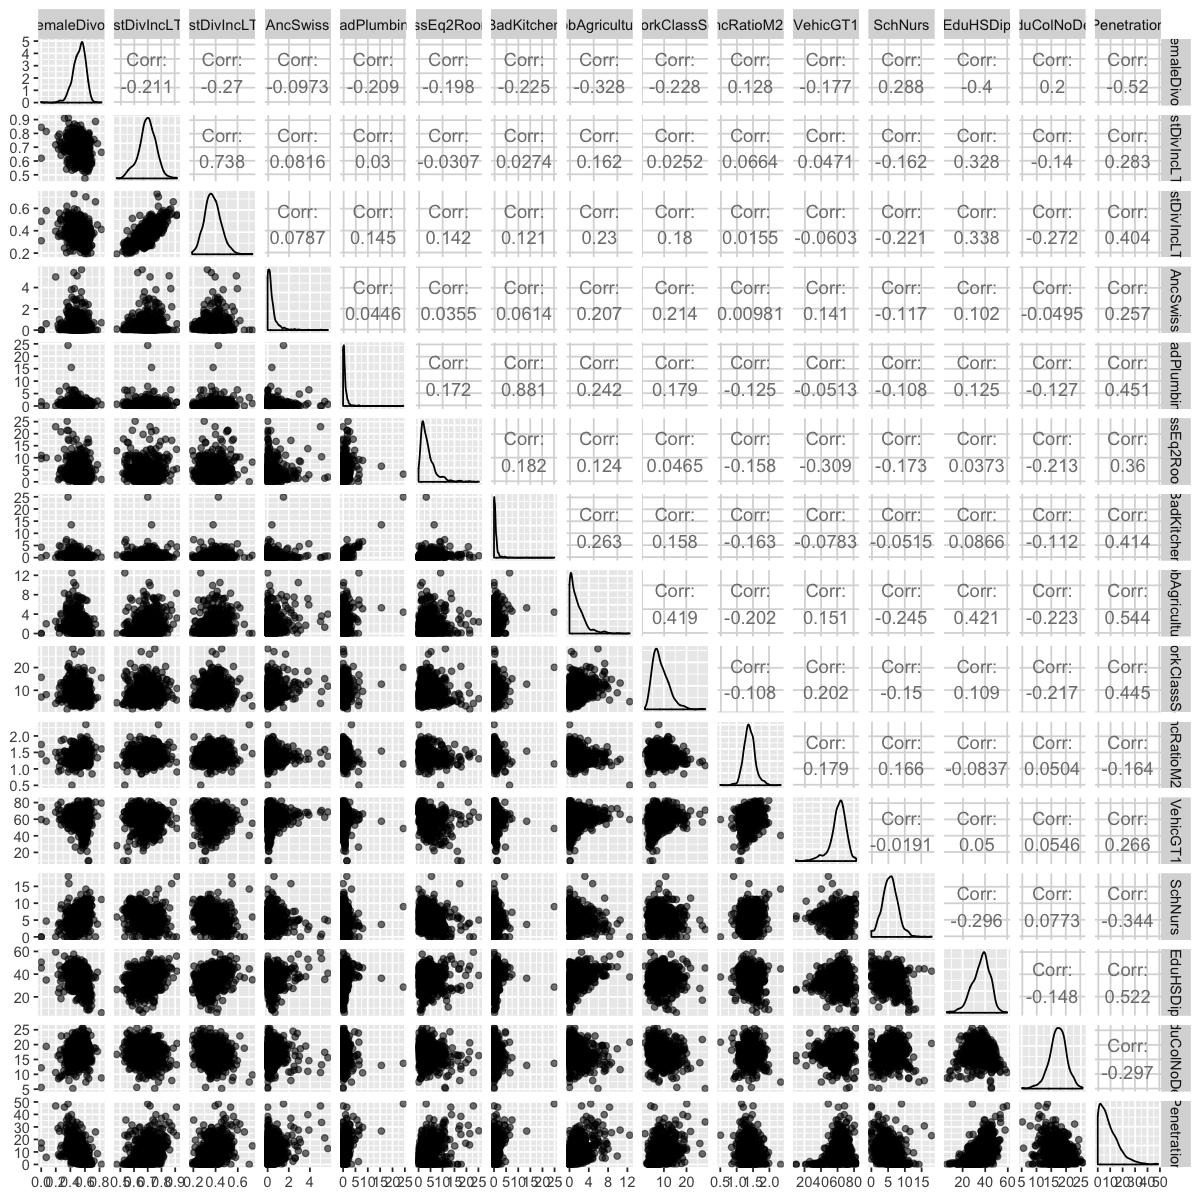

In [44]:
options(repr.plot.width=10, repr.plot.height=10)
ggpairs( train_data_subset, aes( alpha=0.001 ) )

# Regular Linear Model

In [45]:
model0 <- lm( Penetration ~ ., data=train_data_subset )

In [46]:
summary( model0 )


Call:
lm(formula = Penetration ~ ., data = train_data_subset)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.3993  -2.3369  -0.2804   1.9329  15.2693 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -22.52440    2.93277  -7.680 4.70e-14 ***
MarFemaleDivorcees  -7.50162    1.89528  -3.958 8.24e-05 ***
CostDivIncLT25       5.32176    3.48363   1.528 0.127000    
CostDivIncLT15      11.31104    3.06880   3.686 0.000244 ***
AncSwiss             0.98030    0.23534   4.165 3.45e-05 ***
BadPlumbing          1.26269    0.22902   5.514 4.76e-08 ***
LessEq2Rooms         0.74801    0.04796  15.597  < 2e-16 ***
BadKitchen           0.38757    0.23727   1.633 0.102774    
JobAgriculture       0.41190    0.10843   3.799 0.000157 ***
WorkClassSelf        0.37321    0.04526   8.246 6.81e-16 ***
IncRatioM2F         -2.49474    0.85991  -2.901 0.003821 ** 
VehicGT1             0.24610    0.01651  14.906  < 2e-16 ***
SchNurs             -0.15

In [47]:
options( repr.plot.width=7.5, repr.plot.height=5 )

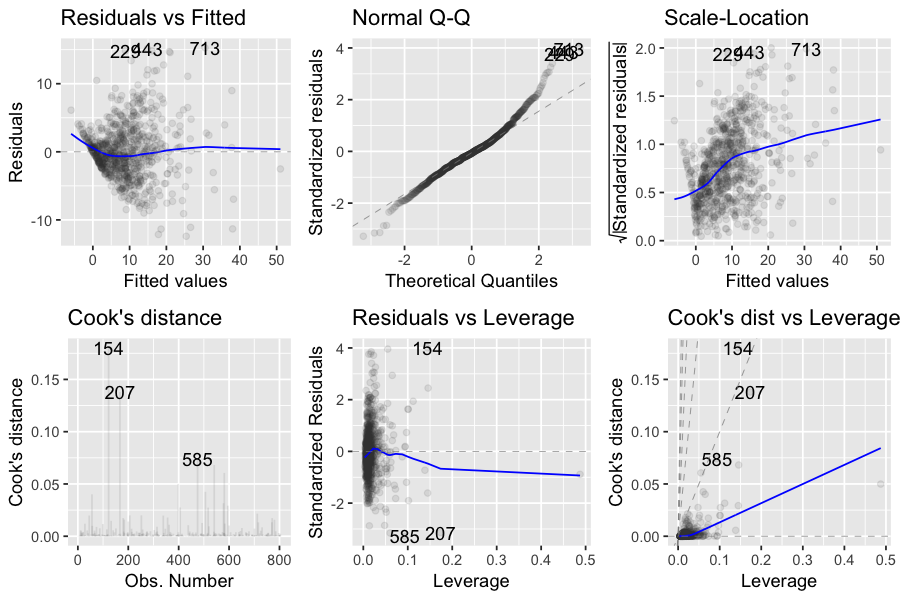

In [48]:
autoplot( model0, which = 1:6, ncol=3, alpha=0.1)

In [49]:
all_pred_results <- all_pred_results %>%
    mutate( lm = predict( model0, test_data ) )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

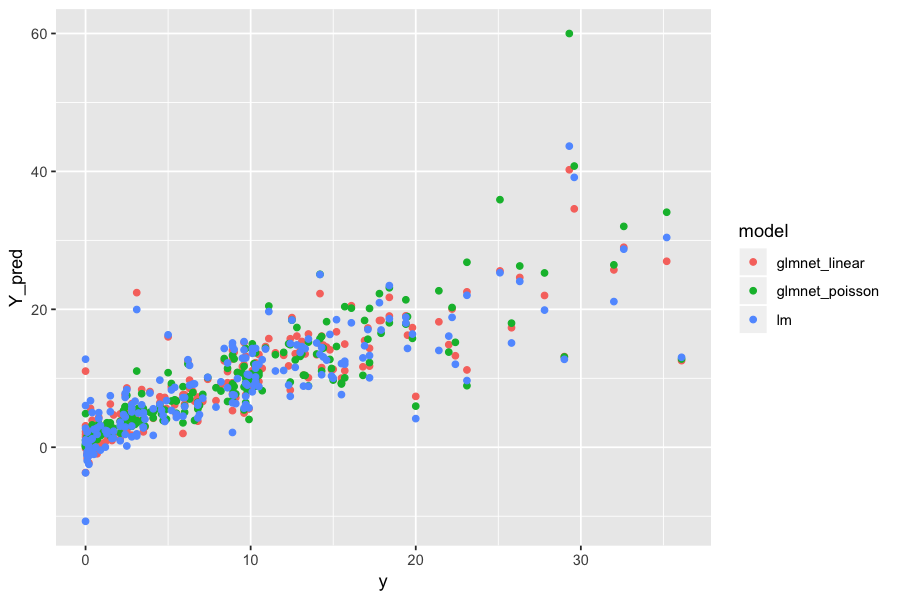

In [50]:
all_pred_results %>% 
    gather( key='model', value='Y_pred', -y ) %>%
    ggplot( aes( y, Y_pred, color=model) ) + geom_point() #+
    #scale_x_continuous(trans = 'log10') + 
    #scale_y_continuous(trans = 'log10') +
    #annotation_logticks()

# GLM model

In [51]:
glm_coefs <- glmnet_cv_result2 %>% 
    coef( s = "lambda.min" ) %>%    # Get the betas from the best model
    tidy %>%                        # Put betas into a data.frame
    select( -column ) %>%           # prune unimportant column named "column"
    arrange( desc( abs( value ) ) ) # Sort by absolute value

Warning message:
“'tidy.dgCMatrix' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.dgTMatrix' is deprecated.
See help("Deprecated")”

In [52]:
glm_coefs %>% head(15)

row,value
<chr>,<dbl>
MarFemaleDivorcees,-0.38459635
CostDivIncLT25,0.38011921
LabFCivilEmployed,0.25292790
(Intercept),0.21780932
AncSubSah,-0.13735906
CostDivIncLT15,0.13313636
AncSwiss,0.04909032
BadKitchen,0.02717750
AncItalian,-0.02633768


In [53]:
# remove row marked '(Intercept)'
interesting_poisson_vars <- c( setdiff( glm_coefs[1:15,'row'],  '(Intercept)'), 'Penetration' )

In [54]:
data_subset <- train_data %>% select( interesting_poisson_vars )

In [55]:
model1 <- glm( Penetration ~ ., data=data_subset, family='quasipoisson' )

In [56]:
summary( model1 )


Call:
glm(formula = Penetration ~ ., family = "quasipoisson", data = data_subset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0784  -1.0049  -0.2477   0.6750   4.6136  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         2.499317   0.457565   5.462 6.30e-08 ***
MarFemaleDivorcees -1.028500   0.178225  -5.771 1.13e-08 ***
CostDivIncLT25      0.848191   0.362827   2.338 0.019650 *  
LabFCivilEmployed  -0.207178   0.420219  -0.493 0.622133    
AncSubSah          -0.357826   0.117860  -3.036 0.002476 ** 
CostDivIncLT15     -0.004742   0.315302  -0.015 0.988005    
AncSwiss            0.085180   0.018595   4.581 5.38e-06 ***
BadKitchen         -0.009841   0.019379  -0.508 0.611718    
AncItalian         -0.043466   0.003932 -11.053  < 2e-16 ***
HouseMultiFamily   -0.044923   0.002607 -17.233  < 2e-16 ***
AncCzech            0.099778   0.029782   3.350 0.000846 ***
BadPlumbing         0.045596   0.019257   2.368 0.018138

In [57]:
glm_preds <- as.numeric( predict( model1, test_data, type='response' ) )

In [58]:
all_pred_results <- all_pred_results %>%
    mutate( glm =  glm_preds )

In [59]:
summary( lm( glm ~ y, all_pred_results ) )


Call:
lm(formula = glm ~ y, data = all_pred_results)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.8162  -2.4198  -0.9994   1.2441  22.4002 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.10600    0.49328   6.297 1.91e-09 ***
y            0.69032    0.04147  16.648  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.639 on 199 degrees of freedom
Multiple R-squared:  0.5821,	Adjusted R-squared:   0.58 
F-statistic: 277.1 on 1 and 199 DF,  p-value: < 2.2e-16


Warning message:
“attributes are not identical across measure variables;
they will be dropped”

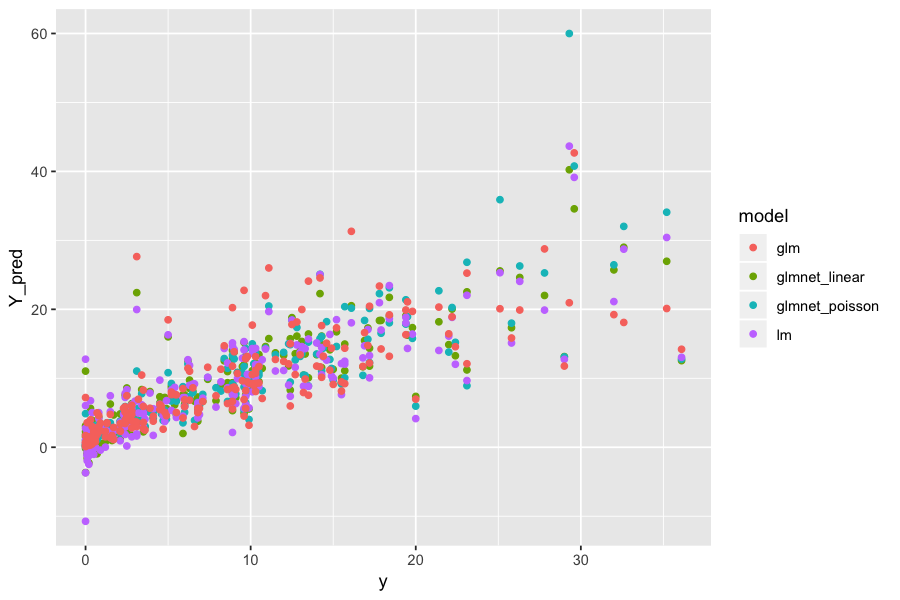

In [60]:
all_pred_results %>% 
    gather( key='model', value='Y_pred', -y ) %>%
    ggplot( aes( y, Y_pred, color=model) ) + geom_point() #+
    #scale_x_continuous(trans = 'log10') + 
    #scale_y_continuous(trans = 'log10') +
    #annotation_logticks()

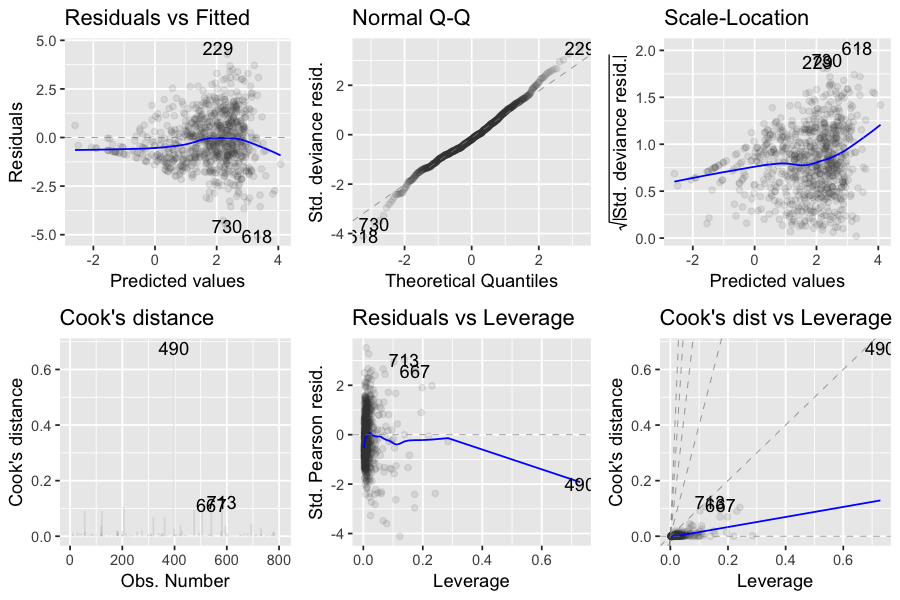

In [61]:
autoplot( model1, which = 1:6, ncol=3, alpha=0.1)

## What about log transforming the skewed vars? 

In [ ]:
log_transform_vars <- c( "MortageLT500", "CommuteAtHome", 'BadPlumbing', "BoatRVVan", 'JobAgriculture', "LessEq2Rooms" )

In [ ]:
transformed_data_subset <- data_subset %>%
    mutate_at( log_transform_vars, ~ log( . + 1) )

In [ ]:
skim_to_wide( transformed_data_subset )

In [ ]:
skim_to_wide( data_subset )

In [ ]:
model2 <- glm( Penetration ~ ., data=transformed_data_subset, family='quasipoisson' )

In [ ]:
summary( model2 )

In [ ]:
autoplot( model2, which = 1:6, ncol=3)

In [ ]:
anova( model1, model2)